# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import matplotlib.image as mpimg
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import cv2  
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


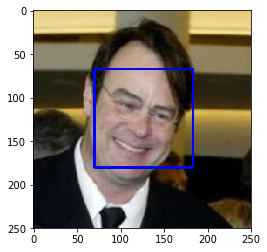

In [3]:
# import cv2                
# import matplotlib.pyplot as plt                        
# %matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
print(f'100 Human Photos: {np.sum([int(face_detector(im)) for im in human_files_short]):} human faces detected')
print(f'100 Dog Photos: {np.sum([int(face_detector(im)) for im in dog_files_short]):} human faces detected')

100 Human Photos: 98 human faces detected
100 Dog Photos: 17 human faces detected


Let's look at the human faces found on dog photos...


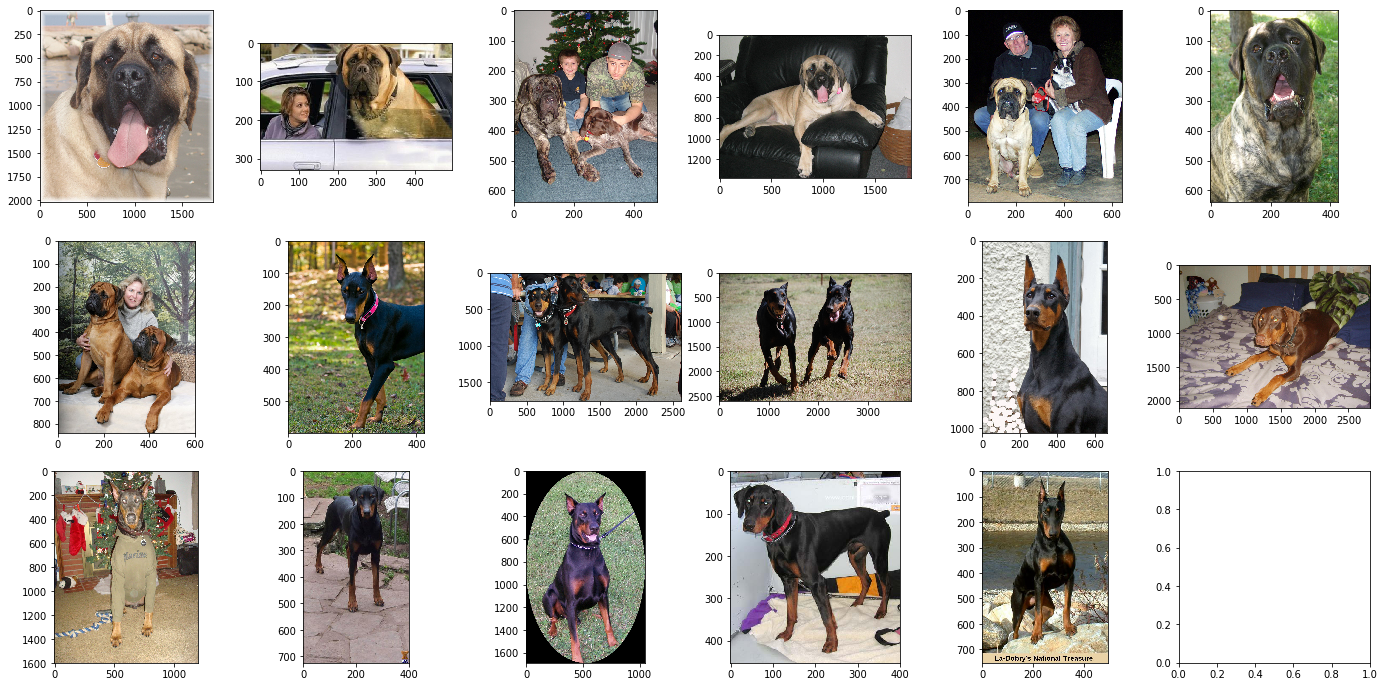

In [6]:
fig, axes = plt.subplots(3, 6, figsize=(24,12))
print("Let's look at the human faces found on dog photos...")
false_positives_list = []
face_count = 0
for im in dog_files_short:
    if face_detector(im):
        false_positives_list.append(im)
#         print(int(face_count/6),(face_count%6))
        test_img=mpimg.imread(im)
        axes[int(face_count/6),(face_count%6)].imshow(test_img);
        face_count += 1

In [7]:
false_positives_list[:]

['/data/dog_images/train/103.Mastiff/Mastiff_06844.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06841.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06860.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06834.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06829.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06856.jpg',
 '/data/dog_images/train/103.Mastiff/Mastiff_06872.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04181.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04209.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04207.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04180.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04186.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04191.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04189.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinsch

__NOTES:__ 
 * We see that some of the dog photos actually did have humans on them. So our face detector's accuarcy (in terms of false positive rate) is a bit better than our simple test above suggested.
 * Evidently, the Haar feature-based cascade classifiers have an elevated rate of false positives in case of some dog breeds, such as Mastiff, Nova Scotia duck tolling retriever, or Bichon Frise. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:23<00:00, 23687923.45it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
#     print('Image shape:', in_transform(image).shape)
    image_transformed = in_transform(image)[:3,:,:].unsqueeze(0)
    image_transformed = image_transformed.to(device)
#     print('Image shape:', image_transformed.shape)
    return torch.argmax(VGG16.forward(image_transformed)).item() # predicted class index

In [11]:
# TEST
VGG16_predict(dog_files_short[0])

243

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted = VGG16_predict(img_path)
    return 151 <= predicted <= 268 # true/false

In [13]:
num_dog_breeds_imagenet1000 = 268 - 150
print('Number of dog breeds in the Imagenet 1000:', num_dog_breeds_imagenet1000)

Number of dog breeds in the Imagenet 1000: 118


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print(f'100 Human Photos: VGG16 detected {np.sum([int(dog_detector(im)) for im in human_files_short]):} dog faces')
print(f'100 Dog Photos:   VGG16 detected {np.sum([int(dog_detector(im)) for im in dog_files_short]):} dog faces')

100 Human Photos: VGG16 detected 0 dog faces
100 Dog Photos:   VGG16 detected 100 dog faces


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [16]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [4]:
# import os
# from torchvision import datasets
# from torch.utils.data.sampler import SubsetRandomSampler

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder('/data/dog_images/train', transform=train_transforms)
test_data =  datasets.ImageFolder('/data/dog_images/test', transform=test_transforms)
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
#### How did we resize the images, and why?
 * For the test/validation data, we applied two consecutive operations:
     * Resize to 255-by-255
     * Crop the center of the image: keep a 224-by-224 part
 * For the train data, we used the `RandomResizedCrop(224)` operation that does both resizing and random crop.
 * The main reason we chose this image size is that it is the smallest size supported by all pretrained models in the Torchvision library. And since we are going to work on implementing the transfer learning a bit later in this project, this seems like a good idea.
 
#### How did we augment the image dataset, and why?
 * We used the following augmentation operations:
   * `RandomRotation(30)`: rotates the image to a random angle, up to 30 degrees;
   * `RandomResizedCrop(224)`: crops a 224x224 area at random from the original image;
   * `RandomHorizontalFlip()`: flips the image horizontally at random (with probability 0.5).
 * The reason for that is that we hope to force our classifier to generalize better, so that it shows a better performance on the images where the objects (i.e., dogs) have unusual poses or spacial orientations.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [19]:
# import torch.nn as nn
# import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define a few useful attributes
        self.num_dog_breeds = 133
        self.input_img_dim = 224
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(  3,  16, 3, padding=1)
        self.conv2 = nn.Conv2d( 16,  32, 3, padding=1)
        self.conv3 = nn.Conv2d( 32,  64, 3, padding=1)
        self.conv4 = nn.Conv2d( 64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # MAX-pooling layer (reduces the feature map size by half)
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (12544 -> 1024)
        self.fc1 = nn.Linear(7*7*256, 1024)
        # linear layer (1024 -> 118)
        self.fc2 = nn.Linear(1024, self.num_dog_breeds)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        ## Define forward behavior
        
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x))) # Image dimention reduction: 224 -> 112
        x = self.pool(F.relu(self.conv2(x))) # Image dimention reduction: 112 -> 56
        x = self.pool(F.relu(self.conv3(x))) # Image dimention reduction: 56 -> 28
        x = self.pool(F.relu(self.conv4(x))) # Image dimention reduction: 28 -> 14
        x = self.pool(F.relu(self.conv5(x))) # Image dimention reduction: 14 -> 7
        # Flatten the image input
        x = x.view(-1, 7*7*256)
        # Fully connected/dropout layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

All CNN's designed for the purpose of computer vision (image reckognition), including the pretrained models that come with Torchvision follow the same general design plan; they all have two major components:
 1. A stack of convolutional layers (which generally, may or may not have activation functions, e.g. sigmoid or ReLU), interlayered with pooling layers (whose main purpose is to reduce the size of the feature map while preserving as much valuable information as possible).
 2. One or several dense (i.e., fully connected) layers. They take the features found in the previous (convolutional) part as an input, and work as a classifier, i.e., a predictive model capable of infering a class based on a list of provided features. 

Convolutional layers have proven to be excellent, virtually unbeatable image feature detectors. And as we know, feature engineering is one of the keys to designing a successful supervised learning model. This explains the success of this two-component configuration. So we followed the same pattern.

 * It is is general rule that the more convolutional layers we add to our CNN architecture, the better our chances are to capture complex patterns on the image.
 * Having a task of traing the model capable of identifying 133 different dog breeds, we know that the number of layers has to be sufficiently large.
 * On the other hand, we would like to keep the computational cost at a reasonable level.
 * So, as a trade-off, we chose an architecture with with 5 convolutional layers. Each of those layers has a ReLU activation function and is followed by a MAX-pooling layer (with both kernel size and stride equal to 2, which cuts the feature map size in half).
 * The convolutional layers are followed by two fully connected layers (with dropout applied to their respective inputs). The first FC layer has a ReLU activation, while the second layer serves as an output and has no activation. Since the second FC layer has the number of output features that matches the number of classes (dog breeds), we can say that it returns a raw score for each class. We can pass these scores further to the `nn.CrossEntropyLoss()`.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
# import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('Checking if CUDA is available...', use_cuda)

Checking if CUDA is available... True


In [22]:
loaders_scratch = {}
loaders_scratch['train'] = trainloader
loaders_scratch['valid'] = validloader
loaders_scratch['test'] = testloader
loaders_scratch.keys()

dict_keys(['train', 'valid', 'test'])

In [23]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # Clear the gradients for all optimized variables
            optimizer.zero_grad()
            # Forward pass
            output = model.forward(data)
            # Estimate the loss
            loss = criterion(output, target)
            # Backprop
            loss.backward()
            # Update the weights
            optimizer.step()
            # Update the train loss
            train_loss += loss.item()/data.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model.forward(data)
            loss = criterion(output, target)
            
            ## update the average validation loss
            valid_loss += loss.item()/data.size(0)
        
        # calculate average loss over an epoch
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path) # 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.004785 	Validation Loss: 0.006749
Validation loss decreased (inf --> 0.006749).  Saving model ...
Epoch: 2 	Training Loss: 0.004769 	Validation Loss: 0.006768
Epoch: 3 	Training Loss: 0.004599 	Validation Loss: 0.006446
Validation loss decreased (0.006749 --> 0.006446).  Saving model ...
Epoch: 4 	Training Loss: 0.004415 	Validation Loss: 0.006169
Validation loss decreased (0.006446 --> 0.006169).  Saving model ...
Epoch: 5 	Training Loss: 0.004316 	Validation Loss: 0.006008
Validation loss decreased (0.006169 --> 0.006008).  Saving model ...
Epoch: 6 	Training Loss: 0.004204 	Validation Loss: 0.006010
Epoch: 7 	Training Loss: 0.004108 	Validation Loss: 0.005694
Validation loss decreased (0.006008 --> 0.005694).  Saving model ...
Epoch: 8 	Training Loss: 0.004055 	Validation Loss: 0.005733
Epoch: 9 	Training Loss: 0.004010 	Validation Loss: 0.005536
Validation loss decreased (0.005694 --> 0.005536).  Saving model ...
Epoch: 10 	Training Loss: 0.003955 	Valida

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.093901


Test Accuracy: 26% (223/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [4]:
## TODO: Specify data loaders
# import os
# from torchvision import datasets
# from torch.utils.data.sampler import SubsetRandomSampler

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder('/data/dog_images/train', transform=train_transforms)
test_data =  datasets.ImageFolder('/data/dog_images/test', transform=test_transforms)
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
loaders_transfer = {}
loaders_transfer['train'] = trainloader
loaders_transfer['valid'] = validloader
loaders_transfer['test'] = testloader
loaders_transfer.keys()

dict_keys(['train', 'valid', 'test'])

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [5]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('Are we currently using CUDA?...', use_cuda)

Are we currently using CUDA?... True


In [5]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Grab the VGG16 model
model_transfer = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.classifier = nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(25088, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(1024, 133))

# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 84903438.45it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

 * Based on all our experiments with pretrained CNN's (transfer learning, style transfer), all pretrained CNN's available via Torchvision, do an excellent job at feature detection, which is what we need them for in this project. I chose VGG16 simply because it was already loaded earlier in this project. Plus, it demonstrated a reasonable forward-pass speed even on CPU, so it seems like a good choice. 
 * Since we don't have to change the convolutional part of the CNN, the main focus here is on the "classifier", the last part of the network that normally consists of one or several fully connected layers. It is noteworthy that all pretrained models we have worked with so far had no more than three dense layers in their "classifier" part. This can be explained the following way. Once we have a comprehensive list of good features (thanks to the convolutional part of the network), one does not need a very complex architecture to build a reliable classifier. In fact, having too many dense layers in this situation drastically increases chances of overfitting. So, based on what we saw in models like VGG16 or ResNet, a two-layer classifier should do the trick. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [5]:
### TODO: select optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # Clear the gradients for all optimized variables
            optimizer.zero_grad()
            # Forward pass
            output = model.forward(data)
            # Estimate the loss
            loss = criterion(output, target)
            # Backprop
            loss.backward()
            # Update the weights
            optimizer.step()
            # Update the train loss
            train_loss += loss.item()/data.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model.forward(data)
            loss = criterion(output, target)
            
            ## update the average validation loss
            valid_loss += loss.item()/data.size(0)
        
        # calculate average loss over an epoch
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path) # 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

In [7]:
n_epochs = 50

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


Epoch: 1 	Training Loss: 0.003047 	Validation Loss: 0.001379
Validation loss decreased (inf --> 0.001379).  Saving model ...
Epoch: 2 	Training Loss: 0.001917 	Validation Loss: 0.001042
Validation loss decreased (0.001379 --> 0.001042).  Saving model ...
Epoch: 3 	Training Loss: 0.001799 	Validation Loss: 0.000999
Validation loss decreased (0.001042 --> 0.000999).  Saving model ...
Epoch: 4 	Training Loss: 0.001656 	Validation Loss: 0.000907
Validation loss decreased (0.000999 --> 0.000907).  Saving model ...
Epoch: 5 	Training Loss: 0.001638 	Validation Loss: 0.000953
Epoch: 6 	Training Loss: 0.001628 	Validation Loss: 0.000913
Epoch: 7 	Training Loss: 0.001567 	Validation Loss: 0.000994
Epoch: 8 	Training Loss: 0.001564 	Validation Loss: 0.001118
Epoch: 9 	Training Loss: 0.001525 	Validation Loss: 0.000938
Epoch: 10 	Training Loss: 0.001574 	Validation Loss: 0.000914
Epoch: 11 	Training Loss: 0.001582 	Validation Loss: 0.001156
Epoch: 12 	Training Loss: 0.001582 	Validation Loss: 0.0

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [11]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.918449


Test Accuracy: 78% (660/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [6]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
import torchvision.transforms as transforms

data_transfer = {"train" : train_data, "valid" : valid_data, "test" : test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
print(class_names[:5])


def predict_breed_transfer(img_path):
    device_str = "cuda" if torch.cuda.is_available() else "cpu"
    # Load the model from file
    if device_str == "cuda":
        model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    else:
        model_transfer.load_state_dict(torch.load('model_transfer_cpu.pt'))
    
    # load the image and return the predicted breed
    # Load the image
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image_transformed = in_transform(image)[:3,:,:].unsqueeze(0)
    image_transformed = image_transformed.to(device)
    # Run the model on this image
    class_idx = torch.argmax(model_transfer.forward(image_transformed)).item()
    # Get the predicted class
    return class_idx, class_names[class_idx]

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute']


In [8]:
# TEST
dog_img_path_1 = '/data/dog_images/test/002.Afghan_hound/Afghan_hound_00116.jpg'
print('Image Path: {}.\nPrediction: {}'.format(dog_img_path_1, predict_breed_transfer(dog_img_path_1)[1]))
dog_img_path_2 = '/data/dog_images/test/005.Alaskan_malamute/Alaskan_malamute_00362.jpg'
print('Image Path: {}.\nPrediction: {}'.format(dog_img_path_2, predict_breed_transfer(dog_img_path_2)[1]))
dog_img_path_3 = '/data/dog_images/test/034.Boxer/Boxer_02413.jpg'
print('Image Path: {}.\nPrediction: {}'.format(dog_img_path_3, predict_breed_transfer(dog_img_path_3)[1]))

Image Path: /data/dog_images/test/002.Afghan_hound/Afghan_hound_00116.jpg.
Prediction: Afghan hound
Image Path: /data/dog_images/test/005.Alaskan_malamute/Alaskan_malamute_00362.jpg.
Prediction: Alaskan malamute
Image Path: /data/dog_images/test/034.Boxer/Boxer_02413.jpg.
Prediction: Boxer


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
# model_transfer.to('cpu')
# torch.save(model_transfer.state_dict(), 'model_transfer_cpu.pt')

In [7]:
# Load the model from file
model_transfer = models.vgg16(pretrained=True)
model_transfer.classifier = nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(25088, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(1024, 133))
model_transfer.load_state_dict(torch.load('model_transfer_cpu.pt'))

In [8]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import time
import os
import random

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
VGG16 = models.vgg16(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image_transformed = in_transform(image)[:3,:,:].unsqueeze(0)
    image_transformed = image_transformed.to(device)
    return torch.argmax(VGG16.forward(image_transformed)).item() # predicted class index

VGG16.to(device)

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def dog_detector(img_path):
    predicted = VGG16_predict(img_path)
    return 151 <= predicted <= 268 # true/false

def get_random_dog_img(idx):
    """
    Choose a random photo of a dog of the predicted breed
    Parameters:
    idx: Class index of the predicted dog breed
    Returns: (str) Image path of a randomly chosen photo of a dog from the predicted breed.
    """
    # Find the directory of the predicted breed
#     dog_breed_dir_list = os.listdir("/data/dog_images/train/")
#     predicted_dog_dir = ''
#     for dog_dir in dog_breed_dir_list:
#         if dog_dir.startswith(f'{idx:03d}'):
#             predicted_dog_dir = dog_dir
#             break
    root_path = "/data/dog_images/train/"
    predicted_dog_dir = data_transfer['train'].classes[idx]
    # Choose a random photo of a dog of the predicted breed
    return root_path+predicted_dog_dir + '/' + \
            random.choice(os.listdir(root_path+predicted_dog_dir + '/'))

def show_img_and_dog(img_path, dog_img_path, title_1='', title_2=''):
    
    # Show both images side by side
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    # Show the image
    img = mpimg.imread(img_path)
    axes[0].imshow(img)
    axes[0].set_title(title_1);
    
    img_dog = mpimg.imread(dog_img_path)
    axes[1].imshow(img_dog)
    axes[1].set_title(title_2);

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    # Is this a human face?
    if face_detector(img_path):
        # What kind of dog does this image look like?
        pred_idx, pred_breed = predict_breed_transfer(img_path)
        
        show_img_and_dog(img_path, get_random_dog_img(pred_idx), 
                         title_1='Humans...', 
                         title_2=f'... and their dog counterparts ({pred_breed:})')
    # Is this a dog image?
    elif dog_detector(img_path):
        # What kind of dog does this image look like?
        pred_idx, pred_breed = predict_breed_transfer(img_path)
        
        show_img_and_dog(img_path, get_random_dog_img(pred_idx), 
                         title_1='Dog...', 
                         title_2=f'... and its relative ({pred_breed:})')
    else:
        print('This is neither a human, nor a dog.')
    
#     time.sleep(1) # pause for 1 sec
    return


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

 * When it comes to human-dog comparison, one has to agree that it is too much like "apples and oranges". However, in some cases one could see correlations in hair color and even the shape of eyes. So we would have to conclude that aside from being fun, our app was not a complete fiasco as it did pick up on some resembling appearance features.

 * The test showed a 78% accuracy in recognizing the dog breed. The images below illustrate that more often than not, the algorithm got it right. And even when it didn't, the similarities in things like coat color, shape of ears, etc. were apparent.
 
 * In order to improve the performance of the algorithm, we could consider the following:
 
    1. It is very possible that the breed prediction accuracy would benefit significantly if we expanded the training dataset. The one provided to us was a good size however, considering the wide variety of appearances within the same breed on the one hand, and blurry cross-breed lines on the other, it is reasonable to suggest that we could benefit from applying the golden principle of Data Science and Machine Learning: "The more data, the better".

    2. Perhaps, we could increase the amount of image augmentation, to ensure more data variability within the dataset and as a result, a better model's ability to generalize.
    
    3. We could also use one of bigger pretrained CNN's (such as ResNet-152) that demonstrated a higher accuracy in the ImageNet1000 challenge.

    4. As far as comparing humans to dogs, perhaps the algorithms would do better if it focused exclusively on shapes rather than colors. So we could try to retrain our model on a set of grayscale images to test that theory.

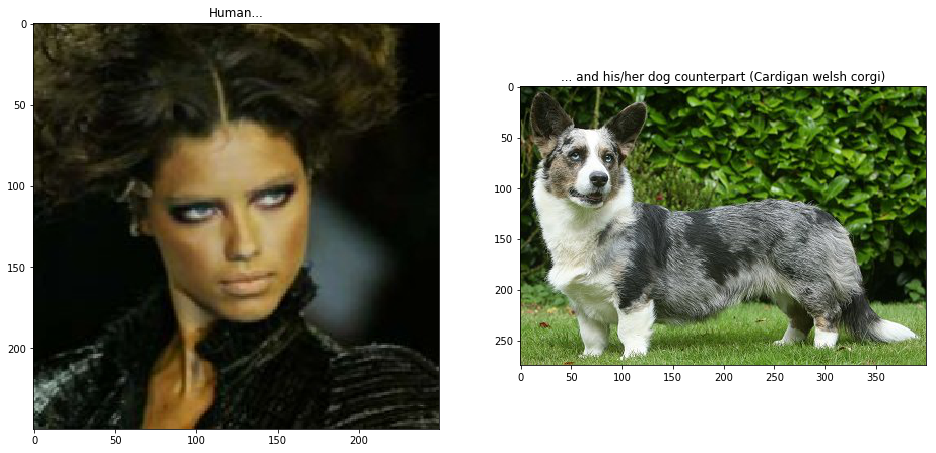

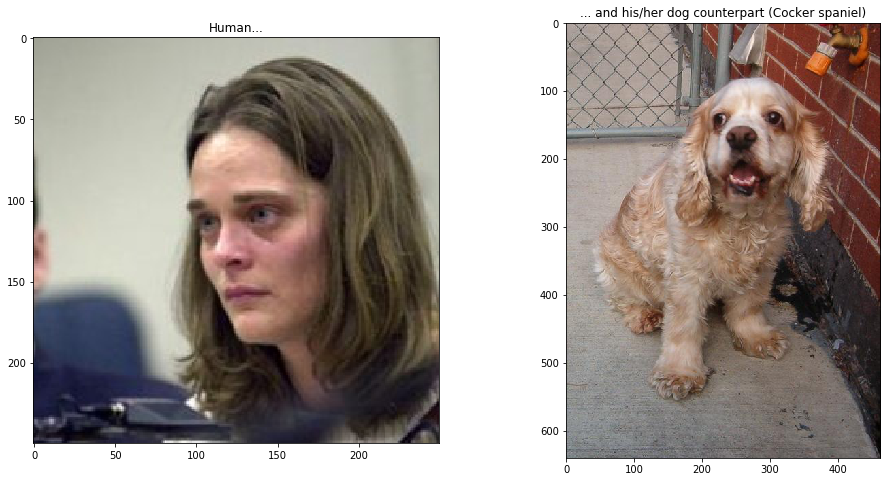

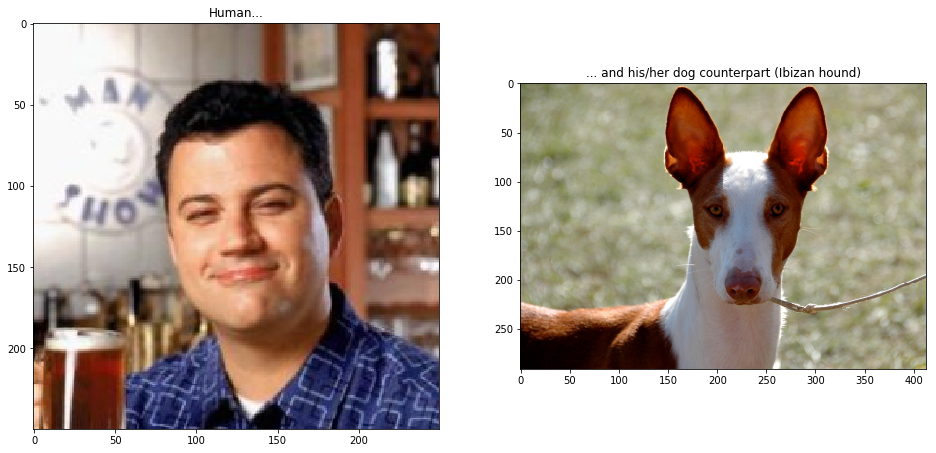

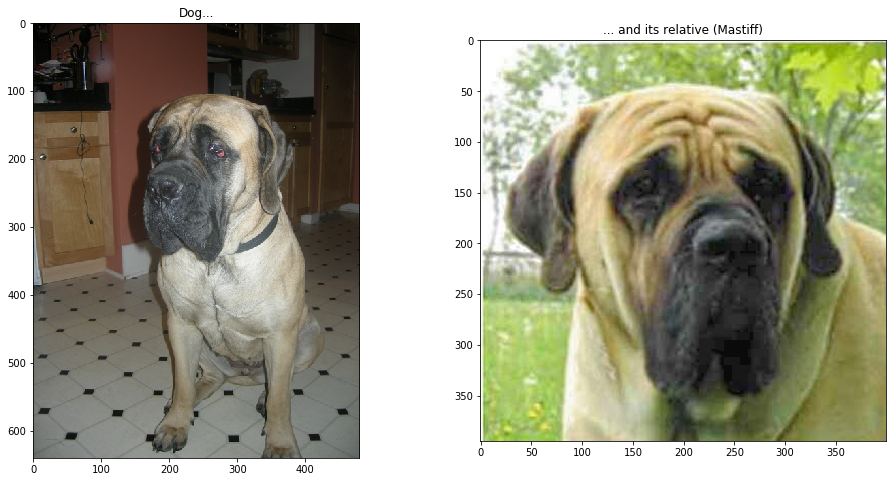

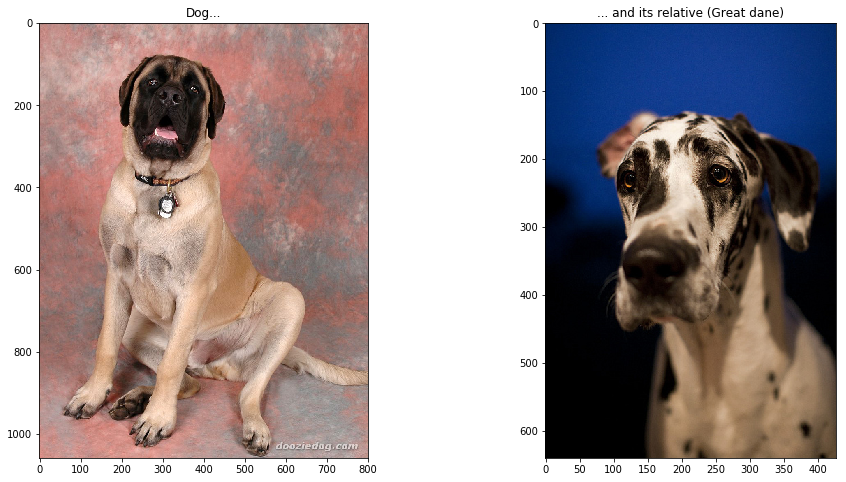

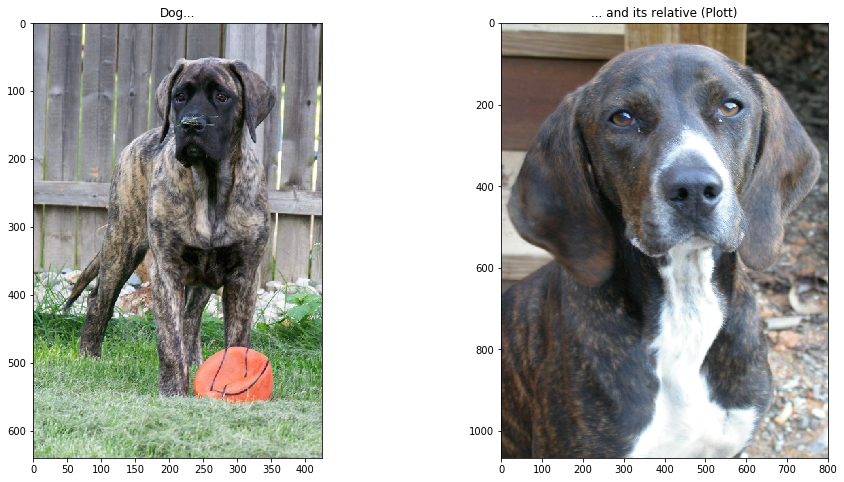

In [24]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[20:23], dog_files[20:23])):
    run_app(file)

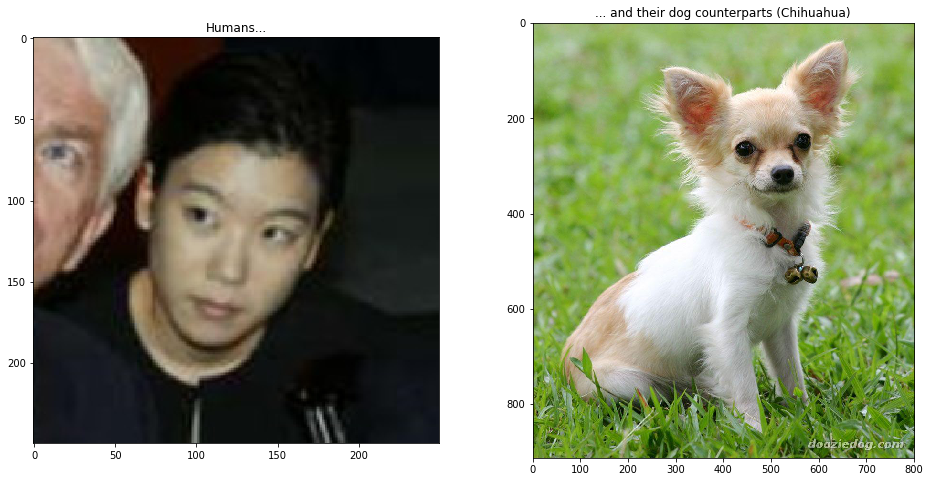

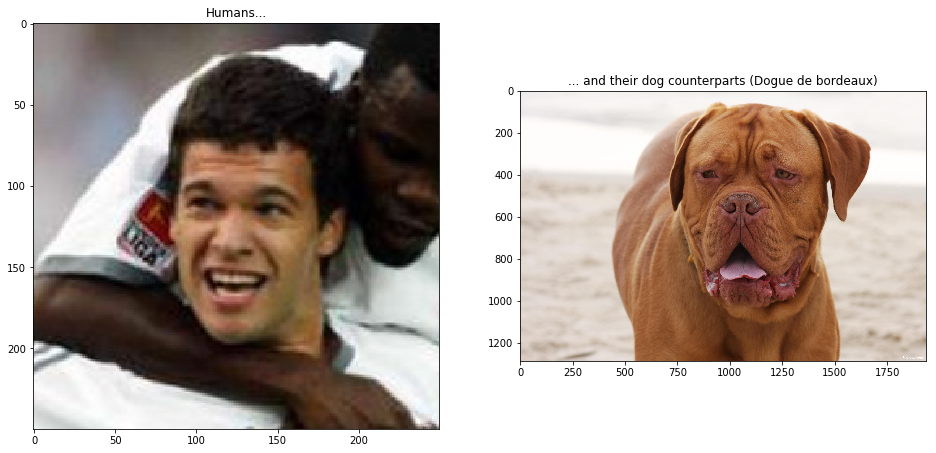

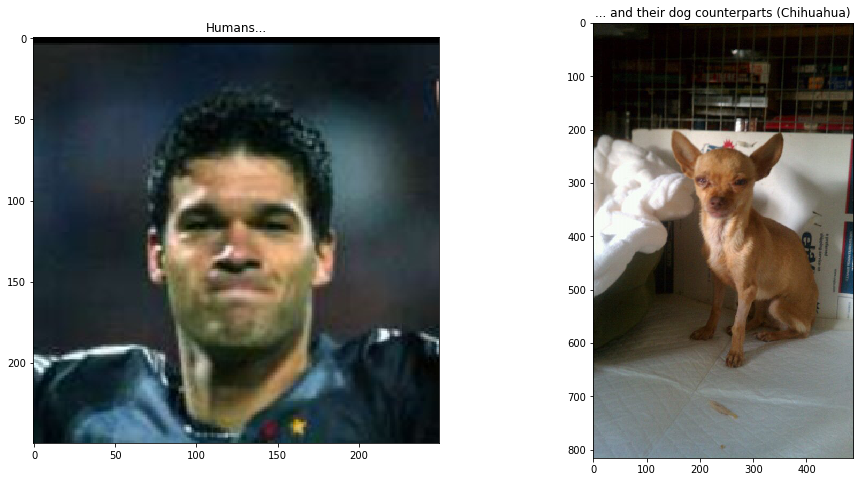

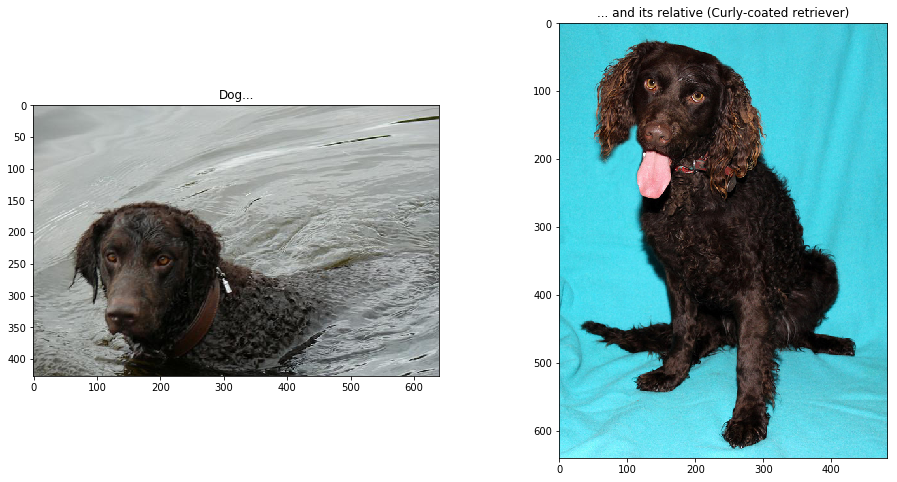

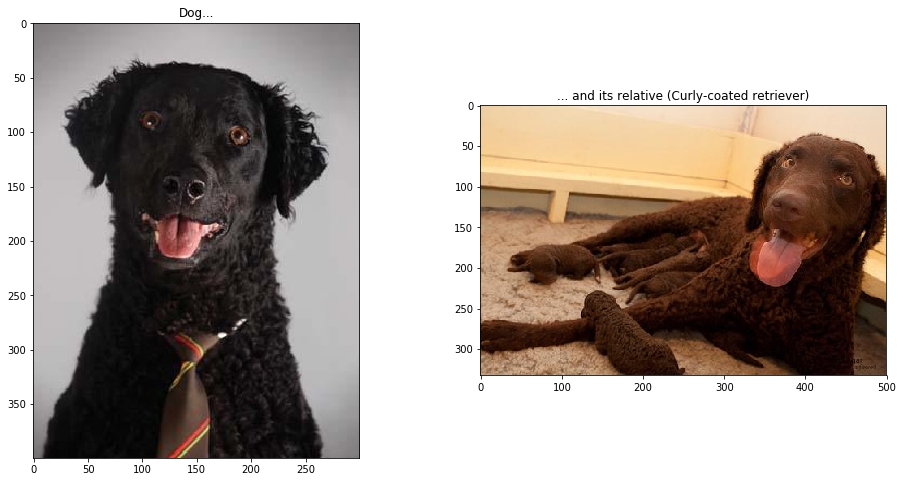

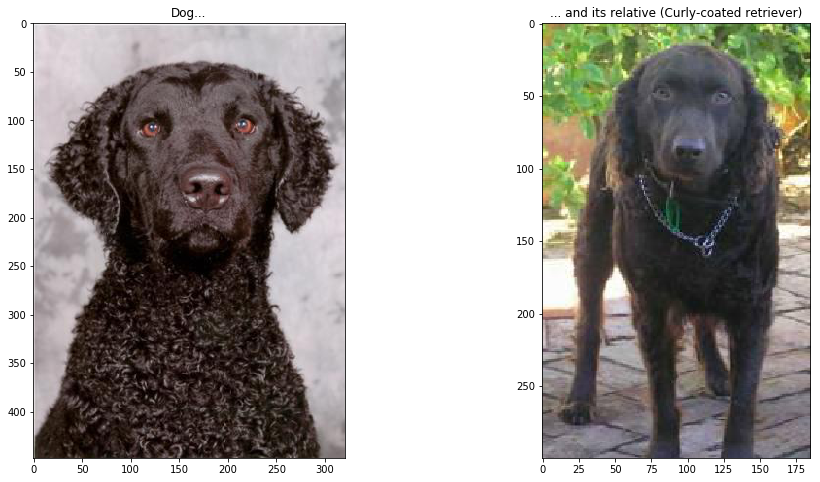

In [9]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[120:123], dog_files[120:123])):
    run_app(file)

As for me,.............


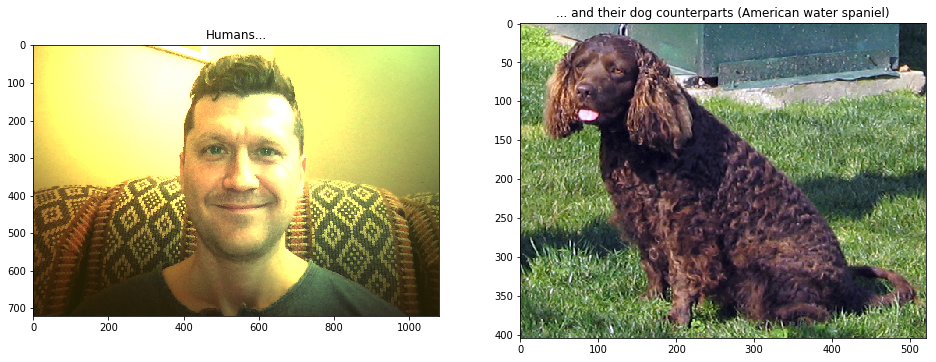

In [12]:
print('As for me,.............')
run_app('KB - Photo on 3-10-19 at 4.24 PM.jpg')